In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F #torch是关于运算的包
import torchvision
from torchvision import datasets,transforms, models #torchvision则是打包了一些数据集
from torch.utils.data import Dataset
from torchvision import transforms as T
from torchnet import meter
from torch.autograd import Variable
import pandas as pd
import numpy as np
import glob
from natsort import natsorted
from PIL import Image
import matplotlib.pyplot as plt
import os
from progressbar import * #进度条
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
label2int = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
int2lable = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [4]:
class TrainAndValData(Dataset):
    def __init__(self, img_path, csv_path, train=True, transforms=None):
        '''
        获得所有图片路径，并划分训练集、验证集
        '''
        self.train = train
        files = natsorted(glob.glob(img_path + '/*'))
        labels = pd.read_csv(csv_path).values[:, 1]
        files_num = len(files)
        break_point = int(0.9*files_num)
        if self.train:
            self.img_name = files[: break_point]
            self.img_label = labels[: break_point]
        else:
            self.img_name = files[break_point: ]
            self.img_label = labels[break_point: ]
        
        #数据增强
        if transforms is None:
            normalize = T.Normalize(mean=[0.485, 0.0456, 0.406], std=[0.229, 0.224, 0.225])
            #训练集用数据增强
            if self.train:
                self.transforms = T.Compose([
                    T.Resize(224),#将输入的`PIL.Image`重新改变大小成给定的`size`，`
                    #size`是最小边的边长。举个例子，如果原图的`height>width`,那么改变大小后的图片大小是`(size*height/width, size)`
                    T.RandomResizedCrop(224),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    #normalize 
                ])
            else:
                self.transforms = T.Compose([
                    T.Resize(256),
                    T.CenterCrop(224),#中心裁剪
                    T.ToTensor(),
                    #normalize 
                ])
    def __len__(self):
        '''
        返回数据集中所有图片的个数
        '''
        return len(self.img_name)
    def __getitem__(self, index):
        '''
        返回一张图片的数据
        '''
        img_path = self.img_name[index]
        img = Image.open(img_path)
        img = self.transforms(img)
        label = label2int[self.img_label[index]]
        return img, label
class TestData(Dataset):
    def __init__(self, img_path, transforms=None):
        files = natsorted(glob.glob(img_path + '/*'))
        self.img_name = files
        if transforms is None:
            normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            self.transforms =  T.Compose([
                T.Resize(224),
                T.ToTensor(),
                #normalize
            ])
    def __len__(self):
        return len(self.img_name)
    def __getitem__(self, index):
        img_path = self.img_name[index]
        img = Image.open(img_path)
        img = self.transforms(img)
        return img

In [5]:
train_img_path = 'data/train'
csv_path = 'data/trainLabels.csv'
test_img_path = 'data/test'
train_dataset = TrainAndValData(train_img_path, csv_path, train=True)
val_dataset = TrainAndValData(train_img_path, csv_path, train=False)
test_dataset = TestData(test_img_path)

In [6]:
print('train len is %d' % len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1])#打印标签
print('val len is %d' % len(val_dataset))
print(val_dataset[0][0].shape)
print(val_dataset[0][1])
print('test len is %d' % len(test_dataset))
print(test_dataset[0].shape)

train len is 45000
torch.Size([3, 224, 224])
6
val len is 5000
torch.Size([3, 224, 224])
7
test len is 300000
torch.Size([3, 224, 224])


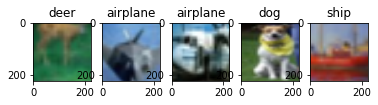

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 5, shuffle=True, num_workers=4)
for i, (data, label) in enumerate(train_dataloader):
    if i<1:
        for j in range(5):
            img = data.numpy()
            y = label.numpy()
            plt.subplot(1, 5, j+1)
            plt.title(int2lable[y[j]])
            plt.imshow(np.transpose(img[j],(1,2,0)))
        plt.show()
    else:
        break

In [10]:
### 定义网络 ###
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [11]:
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [12]:
net = VGG('VGG16')
#print(net)
x = torch.randn(2,3,32,32)
y = net(x)
print(y)
#print(net)

tensor([[ 0.4359, -0.6248,  0.4172, -0.4142, -0.3945, -0.0782,  0.2195,  0.1909,
         -0.5217,  0.4698],
        [ 0.0239,  0.2305,  0.3750, -0.1716, -0.3164, -0.5240, -0.1310, -0.0230,
         -0.3970,  0.5763]], grad_fn=<ThAddmmBackward>)


In [13]:
pre_model = models.vgg16(pretrained=True)
for parma in pre_model.parameters():
    parma.requires_grad = False
pre_model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 10))

In [19]:
def train2(model_path, train_datset, val_dataset):
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4) 
    net = VGG('VGG16')
    ##net = pre_model
    device = torch.device("cuda:2")
    #net = net.to(device)
    net = net.cuda()
    #调整学习率参数
    lr = 0.01
    lr_decay = 0.95
    weight_decay = 1e-4
    pre_train_loss = 100000
    
    # CrossEntropyLoss就是我们需要的损失函数
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    #统计指标
    #loss_meter = meter.AverageValueMeter()
    #保存模型判断条件
    max_val_acc = 0
    pre_epoch = 0
    max_interval_epoch = 10

    
    print("Start Training...")
    for epoch in range(100):
        #训练集
        train_loss = 0
        train_count = 0
        net.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device) # 注意需要复制到GPU
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #更新指标
            train_count += labels.size(0)
            train_loss += loss.item()
        train_loss /= train_count
       
        #验证集
        val_acc = 0
        val_loss = 0
        val_count = 0
        net.eval()
        for i, data in enumerate(valloader):
            inputs, labels = data
            #inputs, labels = inputs.to(device), labels.to(device) # 注意需要复制到GPU
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #更新指标
            val_count += 1
            val_loss += loss.item()
            _, predict = outputs.max(1)
            val_count += labels.size(0)
            val_acc += (predict == labels).sum().item()
        val_acc /= val_count
        val_loss /= val_count
        # print the loss and accuracy
        print('the epoch %d, the train loss is %f, the test loss is %f, the test acc is %f' % (epoch, train_loss, val_loss, val_acc))
        
        #保存模型
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            pre_epoch = epoch
            torch.save(net, model_path)#保存整个神经网络的的结构信息和模型参数信息，save的对象是网络net
        if epoch - pre_epoch > max_interval_epoch:
            print('early stop')
            break
            
        #如果损失不载下降，则降低学习率
        if train_loss > pre_train_loss:
            lr = lr*lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        pre_train_loss = pre_train_loss
    print("Done Training!")

In [20]:
model_path = 'model/vgg/pytorch/vgg_16.pkl'
train2(model_path, train_dataset, val_dataset)

Start Training...
the epoch 0, the train loss is 0.016957, the test loss is 0.016603, the test acc is 0.203373


/home/lhw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


the epoch 1, the train loss is 0.015310, the test loss is 0.014692, the test acc is 0.275000
the epoch 2, the train loss is 0.014714, the test loss is 0.019851, the test acc is 0.167262
the epoch 3, the train loss is 0.013812, the test loss is 0.015094, the test acc is 0.303571
the epoch 4, the train loss is 0.013247, the test loss is 0.014962, the test acc is 0.329563
the epoch 5, the train loss is 0.012849, the test loss is 0.015721, the test acc is 0.337698
the epoch 6, the train loss is 0.012475, the test loss is 0.013648, the test acc is 0.382540
the epoch 7, the train loss is 0.012150, the test loss is 0.010990, the test acc is 0.476984
the epoch 8, the train loss is 0.011619, the test loss is 0.010831, the test acc is 0.502381
the epoch 9, the train loss is 0.011036, the test loss is 0.009063, the test acc is 0.580556
the epoch 10, the train loss is 0.010794, the test loss is 0.013355, the test acc is 0.444048
the epoch 11, the train loss is 0.010644, the test loss is 0.010027, 

Process Process-356:
Process Process-354:
Process Process-355:
Process Process-353:
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
Traceb

KeyboardInterrupt: 

In [30]:
def submit(model_path, test_dataset, output_file):
    #加载模型
    net = torch.load(model_path)#加载整个网络和参数
    #device = torch.device("cuda:2")
    #net = net.to(device)
    net = net.cuda()
    
    #数据
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    total = len(test_dataset)
    
    f = open(output_file, 'w')
    f.write('id,label\n')
    test_count = 0
    pbar = ProgressBar().start()
    for i, data in enumerate(test_dataloader):
        pbar.update(int((test_count / (total - 1)) * 100))#进度条
        time.sleep(0.01) 
        
        inputs = data
        #inputs = inputs.to(device)
        inputs = inputs.cuda()
        outputs = net(inputs)
        outputs = outputs.cuda()
        #_, predict = outputs.max(1)
        #print([predict[0].data.cpu().numpy()][0].shape)
        for j in range(len(outputs)):
            f.write("".join([str(test_count+j+1), ',', int2lable[outputs[j].data.cpu().numpy().argmax()], '\n']))
        test_count += len(outputs)
    f.close()
    pbar.finish()
    print('Finish!')

In [31]:
model_path = 'model/vgg/pytorch/vgg_16.pkl'
output_file = "submission.csv"
submit(model_path, test_dataset, output_file)

Finish!


In [10]:
use_gpu = torch.cuda.is_available()

In [14]:
pre_model = models.vgg16(pretrained=True)
for parma in pre_model.parameters():
    parma.requires_grad = False

In [15]:
for parma in pre_model.parameters():
    parma.requires_grad = False
pre_model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 10))

In [14]:
def val(model, dataloder):
    '''
    计算模型在验证集上的准确率等信息
    '''
   #把模型设为验证模式
    model.eval()
    #confusion_matrix = meter.ConfusionMeter(10)
    criterion = nn.CrossEntropyLoss()
    loss_meter = meter.AverageValueMeter()
    correct = 0
    total = 0
    for i, data in enumerate(dataloder):
        input, lable = data
        val_input = Variable(input)#volatile属性为True的节点不会求导
        val_label = Variable(lable.long())

        val_input = val_input.cuda()
        val_label = val_label.cuda()
        output = model(val_input)
        _, predict = output.max(1)
        total += val_label.size(0)
        correct += (predict == val_label).sum().item()
        #_, pred = torch.max(output.data, 1)
        loss = criterion(output, val_label)
        loss_meter.add(loss.item())
        #confusion_matrix.add(output.data.squeeze(), val_label.long())
    #把模型恢复为训练模式
    model.train()
    #cm_value = confusion_matrix.value()
    accuracy = correct / total
    '''
    for i in range(10):
        accuracy += cm_value[i][i]
    accuracy /= (cm_value.sum())
    '''
    return loss_meter.value()[0], accuracy

In [15]:
def train():
    #模型
    #model = VGG('VGG16')
    model = pre_model
    #device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

    model = model.cuda()
    model_path = 'model/vgg/pytorch/vgg_16.pkl'
    #数据
    batch_size = 128
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=4)
    #目标函数和优化器
    criterion = nn.CrossEntropyLoss()
    lr = 0.001
    lr_decay = 0.95
    weight_decay = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay =weight_decay)
    #统计指标
    loss_meter = meter.AverageValueMeter()
    confusion_matrix = meter.ConfusionMeter(10)
    previous_loss = 1e100#训练集
    #测试集
    val_previous_acc = 0
    val_previous_epoch = 0
    max_interval_eoch = 10
    
    #训练
    max_epoch = 100
    for epoch in range(max_epoch):
        loss_meter.reset()
        confusion_matrix.reset()
        
        correct = 0
        total = 0
        train_loss = 0
        for i, (data, label) in enumerate(train_dataloader):
            input = Variable(data)
            target = Variable(label)
            input = input.cuda()
            target = target.cuda()
            optimizer.zero_grad()#把梯度置零
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            #print(output.data.shape)
            #print(input.data.shape)
            #更新指标
            loss_meter.add(loss.item())
            confusion_matrix.add(output.data, target.data)
            
            
        print('epoch is %d, train loss is %f' %(epoch, loss_meter.value()[0]), end=' ')
        #在验证集上验证
        val_loss, val_accuracy = val(model, val_dataloader)
        print('val loss is %f, val acc is %f' %(val_loss, val_accuracy))
        #print(val_cm)
        if val_previous_acc < val_accuracy:
            val_previous_acc = val_accuracy
            previous_epoch = epoch
            torch.save(model, model_path)
        if epoch - previous_epoch > max_interval_eoch:
            break
        #如果损失不载下降，则降低学习率
        if loss_meter.value()[0] > previous_loss:
            lr = lr*lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        previous_loss = loss_meter.value()[0]

In [16]:
train()

epoch is 0, train loss is 1.572603 val loss is 0.880093, val acc is 0.705800
epoch is 1, train loss is 1.399193 val loss is 0.773152, val acc is 0.752400
epoch is 2, train loss is 1.361973 val loss is 0.750147, val acc is 0.756200
epoch is 3, train loss is 1.337704 val loss is 0.779289, val acc is 0.757200
epoch is 4, train loss is 1.319907 val loss is 0.734661, val acc is 0.766600
epoch is 5, train loss is 1.310245 val loss is 0.737105, val acc is 0.773800
epoch is 6, train loss is 1.295978 val loss is 0.772449, val acc is 0.762200
epoch is 7, train loss is 1.288612 val loss is 0.740940, val acc is 0.775400
epoch is 8, train loss is 1.280788 val loss is 0.740620, val acc is 0.782400
epoch is 9, train loss is 1.280856 val loss is 0.728799, val acc is 0.778000
epoch is 10, train loss is 1.265980 val loss is 0.763182, val acc is 0.776200
epoch is 11, train loss is 1.261254 val loss is 0.697446, val acc is 0.786400
epoch is 12, train loss is 1.255103 val loss is 0.745085, val acc is 0.777